문장을 입력해서 이진분류하는 모델에 대해서 알아보겠습니다. 언어가 시계열적인 의미가 있으므로, 이 언어를 문자로 표현한 문장도 시계열적인 의미가 있습니다. 모델에 입력하기 위해서 문장을 시계열수치로 인코딩하는 방법과 여러가지 이진분류 모델을 구성해보고, 학습 결과를 살펴보겠습니다. 이 모델들은 문장 혹은 시계열수치로 양성/음성을 분류하거나 이벤트 발생 유무를 감지하는 문제를 풀 수 있습니다. 

---
### 데이터셋 준비

IMDB에서 제공하는 영화 리뷰 데이터셋을 이용하겠습니다. 이 데이터셋은 훈련셋 25,000개, 시험셋 25,000개의 샘플을 제공합니다. 라벨은 1과 0으로 좋아요/싫어요로 지정되어 있습니다. 케라스에서 제공하는 imdb의 load_data() 함수을 이용하면 데이터셋을 쉽게 얻을 수 있습니다. 데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타냅니다. 모든 단어를 고려할 수 없으므로 빈도수가 높은 단어를 위주로 데이터셋을 생성합니다. 20,000번째로 많이 사용하는 단어까지만 데이터셋으로 만들고 싶다면, num_words 인자에 20000이라고 지정하면 됩니다. 

In [ ]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

훈련셋의 데이터가 어떻게 구성되어 있는 지 살펴보겠습니다. x_train을 출력하면 다음과 같습니다.

In [ ]:
print(x_train)

총 25000개의 샘플이 있으며, 각 샘플은 영화 리뷰 한 건을 의미하며, 단어의 인덱스로 구성되어 있습니다. 'num_words=20000'으로 지정했기 때문에 빈도수가 20,000을 넘는 단어는 보이지가 않습니다. 훈련셋 25,000개를 다시 훈련셋 20,000개와 검증셋 5,000개로 분리합니다.

In [ ]:
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

리뷰의 길이가 다르니 각 샘플의 길이가 다르겠죠? 적개는 수십 단어로 많게는 천 개 이상의 단어로 구성되어 있습니다. 모델의 입력으로 사용하려면 고정된 길이로 만들어야 하므로 케라스에서 제공되는 전처리 함수인 sequence의 pad_sequences() 함수를 사용합니다. 이 함수는 두 가지 역할을 수행합니다. 
* 문장을 maxlen 인자로 지정된 길이로 맞춰줍니다. 예를 들어 200으로 지정했다면 200보다 짧은 문장은 0으로 채워서 200단어로 맞춰주고 200보다 긴 문장은 200단어까지만 잘라냅니다.
* (num_samples, num_timesteps)으로 2차원의 numpy 배열로 만들어줍니다. maxlen을 200으로 지정하였다면, num_timesteps도 200이 됩니다.

In [ ]:
x_train = sequence.pad_sequences(x_train, maxlen=200)
x_val = sequence.pad_sequences(x_val, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

---
### 레이어 준비

본 장에서 새롭게 소개되는 블록들은 다음과 같습니다.

|블록|이름|설명|
|:-:|:-:|:-|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Dataset2D_s.png)|2D Input data|2차원의 입력 데이터입니다. 주로 영상 데이터를 의미하며, 너비, 높이, 채널수로 구성됩니다.
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Conv2D_s.png)|Conv2D|필터를 이용하여 영상 특징을 추출하는 컨볼루션 레이어입니다.|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_MaxPooling2D_s.png)|MaxPooling2D|영상에서 사소한 변화가 특징 추출에 크게 영향을 미치지 않도록 해주는 맥스풀링 레이어입니다.|
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Flatten_s.png)|Flatten|2차원의 특징맵을 전결합층으로 전달하기 위해서 1차원 형식으로 바꿔줍니다.
|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Activation_relu_2D_s.png)|relu|활성화 함수로 주로 Conv2D 은닉층에 사용됩니다.|

In [ ]:
x_train.shape

In [ ]:
y_test.shape

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 25s - loss: 0.4136 - acc: 0.7916 - val_loss: 0.3069 - val_acc: 0.8728
Epoch 2/2
20000/20000 [==============================] - 25s - loss: 0.0534 - acc: 0.9810 - val_loss: 0.4522 - val_acc: 0.8484


Using Theano backend.


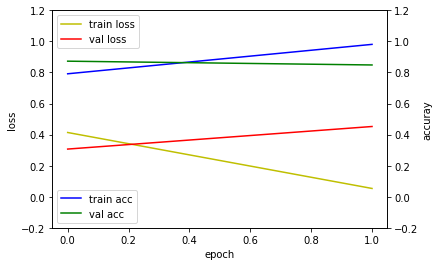

24640/25000 [============================>.] - ETA: 0s## evaluation loss and_metrics ##
[0.46098566806793212, 0.84436000003814693]


In [1]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Flatten

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
#yhat_test = model.predict(xhat_test, batch_size=64)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 139s - loss: 0.4392 - acc: 0.7882 - val_loss: 0.3288 - val_acc: 0.8658
Epoch 2/2
20000/20000 [==============================] - 140s - loss: 0.2295 - acc: 0.9137 - val_loss: 0.3181 - val_acc: 0.8702


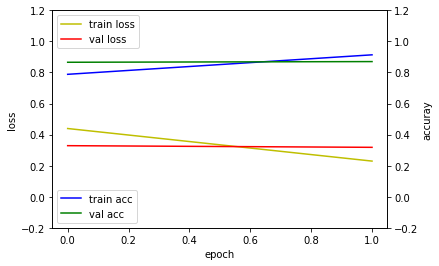

25000/25000 [==============================] - 37s    
## evaluation loss and_metrics ##
[0.34819652654647826, 0.86111999996185307]


In [2]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
#yhat_test = model.predict(xhat_test, batch_size=64)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 156s - loss: 0.5076 - acc: 0.7463 - val_loss: 0.3792 - val_acc: 0.8356
Epoch 2/2
20000/20000 [==============================] - 158s - loss: 0.3221 - acc: 0.8693 - val_loss: 0.3877 - val_acc: 0.8260


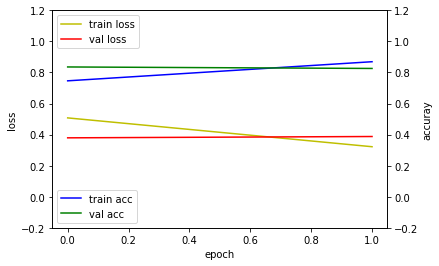

25000/25000 [==============================] - 41s    
## evaluation loss and_metrics ##
[0.38814106165885925, 0.82943999999999996]


In [3]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기


# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
#yhat_test = model.predict(xhat_test, batch_size=64)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 68s - loss: 0.4382 - acc: 0.7823 - val_loss: 0.2904 - val_acc: 0.8762
Epoch 2/2
20000/20000 [==============================] - 67s - loss: 0.2153 - acc: 0.9157 - val_loss: 0.3163 - val_acc: 0.8690


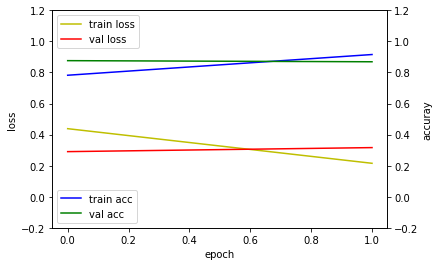

24960/25000 [============================>.] - ETA: 0s## evaluation loss and_metrics ##
[0.32697385798454287, 0.86023999996185307]


In [4]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기

# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
#yhat_test = model.predict(xhat_test, batch_size=64)

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 114s - loss: 0.4069 - acc: 0.8014 - val_loss: 0.3015 - val_acc: 0.8768
Epoch 2/2
20000/20000 [==============================] - 113s - loss: 0.1942 - acc: 0.9268 - val_loss: 0.3114 - val_acc: 0.8774


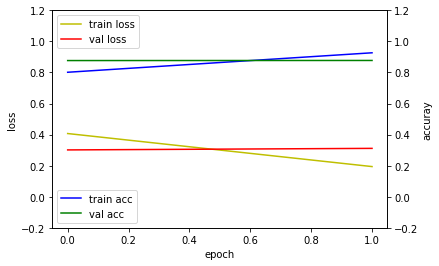

25000/25000 [==============================] - 43s    
## evaluation loss and_metrics ##
[0.34212661021232604, 0.863719999961853]


In [5]:
# 0. 사용할 패키지 불러오기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D

max_features = 20000
text_max_words = 200

# 1. 데이터셋 생성하기


# 훈련셋과 시험셋 불러오기
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 훈련셋과 검증셋 분리
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

# 데이터셋 전처리 : # cut texts after this number of words (among top max_features most common words)
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

# 2. 모델 구성하기
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# 3. 모델 학습과정 설정하기
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=2, batch_size=64, validation_data=(x_val, y_val))

# 5. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. 모델 평가하기
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

# 7. 모델 사용하기
#yhat_test = model.predict(xhat_test, batch_size=64)

---
### 데이터셋 준비

입력 x에 대해 2를 곱해 두 배 정도 값을 갖는 출력 y가 되도록 데이터셋을 생성해봤습니다. 선형회귀 모델을 사용한다면 Y = w * X + b 일 때, w가 2에 가깝고, b가 0.16에 가깝게 되도록 학습시키는 것이 목표입니다.

In [ ]:
import numpy as np

# 데이터셋 생성
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

# 데이터셋 확인
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x_train, y_train, 'ro')
plt.plot(x_test, y_test, 'bo')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_5.png)

---
### 레이어 준비

수치예측 모델에 사용할 레이어는 `Dense`와 `Activation`입니다. `Activation`에는 은닉층(hidden layer)에 사용할 `relu`를 준비했습니다. 데이터셋은 일차원 벡터만 다루도록 하겠습니다.

|종류|구분|상세구분|브릭|
|:-:|:-:|:-:|:-:|
|데이터셋|Vector|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Dataset_Vector_s.png)|
|레이어|Dense||![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Dense_s.png)|
|레이어|Activation|relu|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Activation_Relu_s.png)|

---
### 모델 준비

수치예측을 하기 위해 `선형회귀 모델`, `퍼셉트론 모델`, `다층퍼셉트론 모델`, `깊은 다층퍼셉트론 모델`을 준비했습니다.

#### 선형회귀 모델

가장 간단한 1차 선형회귀 모델로 수치예측을 해보겠습니다. 아래 식에서 x, y는 우리가 만든 데이터셋이고, 회귀분석을 통해서, w와 b값을 구하는 것이 목표입니다. 

    Y = w * X + b
   
w와 b값을 구하게 되면, 임의의 입력 x에 대해서 출력 y가 나오는 데 이것이 예측 값입니다. w, b 값은 분산, 공분산, 평균을 이용하여 쉽게 구할 수 있습니다. 

    w = np.cov(X, Y, bias=1)[0,1] / np.var(X)
    b = np.average(Y) - w * np.average(X)
    
간단한 수식이지만 이 수식을 도출하기란 꽤나 복잡습니다. 오차를 최소화하는 극대값을 구하기 위해 편미분을 수행하고, 다시 식을 전개하는 등등의 과정이 필요합니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_0.png)    

#### 퍼셉트론 모델

Dense 레이어가 하나이고, 뉴런의 수도 하나인 가장 기본적인 퍼셉트론 모델입니다. 즉 웨이트(w) 하나, 바이어스(b) 하나로 전형적인 Y = w * X + b를 풀기 위한 모델입니다. 수치 예측을 하기 위해서 출력 레이어에 별도의 활성화 함수를 사용하지 않았습니다. w, b 값이 손으로 푼 선형회귀 최적해에 근접하려면 경우에 따라 만번이상의 에포크가 필요합니다. 실제로 사용하지는 않는 모델이지만 선형회귀부터 공부하시는 분들에게는 입문 모델로 나쁘지 않습니다.

    model = Sequential()
    model.add(Dense(1, input_dim=1))
        
![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_1m.png)

#### 다층퍼셉트론 모델

Dense 레이어가 두 개인 다층퍼셉트론 모델입니다. 첫 번째 레이어는 64개의 뉴런을 가진 Dense 레이어이고 오류역전파가 용이한 `relu` 활성화 함수를 사용하였습니다. 출력 레이어인 두 번째 레이어는 하나의 수치값을 예측을 하기 위해서 1개의 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않았습니다.

    model = Sequential()
    model.add(Dense(64, input_dim=1, activation='relu'))
    model.add(Dense(1))

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_2m.png)

#### 깊은 다층퍼셉트론 모델

Dense 레이어가 총 세 개인 다층퍼셉트론 모델입니다. 첫 번째, 두 번째 레이어는 64개의 뉴런을 가진 Dense 레이어이고 오류역전파가 용이한 `relu` 활성화 함수를 사용하였습니다. 출력 레이어인 세 번째 레이어는 하나의 수치값을 예측을 하기 위해서 1개의 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않았습니다.

    model = Sequential()
    model.add(Dense(64, input_dim=1, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_3m.png)    

---
### 전체 소스

앞서 살펴본 `선형회귀 모델`, `퍼셉트론 모델`, `다층퍼셉트론 모델`, `깊은 다층퍼셉트론 모델`의 전체 소스는 다음과 같습니다. 

#### 다층퍼셉트론 모델

In [ ]:
# 다층퍼셉트론 모델로 수치예측하기

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='mse')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

# 5. 모델 평가하기
loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss : ' + str(loss))

# 6. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### 깊은 다층퍼셉트론 모델

In [ ]:
# 깊은 다층퍼셉트론 모델로 수치예측하기

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. 데이터셋 준비하기
x_train = np.random.random((1000, 1))
y_train = x_train * 2 + np.random.random((1000, 1)) / 3.0
x_test = np.random.random((100, 1))
y_test = x_test * 2 + np.random.random((100, 1)) / 3.0

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(64, input_dim=1, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(optimizer='rmsprop', loss='mse')

# 4. 모델 학습시키기
hist = model.fit(x_train, y_train, epochs=50, batch_size=64)

# 5. 모델 평가하기
loss = model.evaluate(x_test, y_test, batch_size=32)
print('loss : ' + str(loss))

# 6. 학습과정 확인하기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 1.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

---

### 학습결과 비교

퍼셉트론 > 다층퍼셉트론 > 깊은 다층퍼셉트론 순으로 학습이 좀 더 빨리 되는 것을 확인할 수 있습니다.

|퍼셉트론|다층퍼셉트론|깊은 다층퍼셉트론|
|:-:|:-:|:-:|
|![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_6.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_7.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_8.png)|

---

### 결론

수치예측을 위한 퍼셉트론, 다층퍼셉트론, 깊은 다층퍼셉트론 모델을 살펴보고, 그 성능을 확인 해봤습니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-8-12-Numerical_Prediction_Model_Recipe_4m.png)

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)